Valid tickers for this code, ['AMC', 'AMD', 'BBBY', 'F', 'GME', 'NVDA', 'PLTR', 'PROG', 'TSLA', 'X']

In [71]:
import urllib.request
ticker='F' 
url = 'http://cs301.pintoenterprisetech.com/'+ticker+'.csv'
urllib.request.urlretrieve(url, ticker+".csv")
url = 'http://cs301.pintoenterprisetech.com/'+ticker+'historical.csv'
urllib.request.urlretrieve(url, ticker+"historical.csv")

('Fhistorical.csv', <http.client.HTTPMessage at 0x7fe1eac087d0>)

In [72]:
import pandas as pd
import datetime

In [73]:
df = pd.read_csv(ticker+".csv")

In [74]:
tickerdf = df.drop(['ticker'], axis=1).rename(columns={"timestamp" : "ds", "avg(sentiment)" : "avg(sentiment)"})

In [75]:
tickerdf.head()

,ds,avg(sentiment)
0,2021-10-31 03:25:34,0.3804
1,2021-10-31 03:36:11,0.4215
2,2021-10-31 03:44:12,0.0000
3,2021-10-31 04:50:25,0.0000
4,2021-10-31 05:20:13,0.7964


In [76]:
tickerpricesDf = pd.read_csv(ticker+'historical.csv')
tickerpricesDf['Date'] = pd.to_datetime(tickerpricesDf['Date'])
tickerpricesDf.set_index('Date', inplace=True)
tickerpricesDf = tickerpricesDf.resample('D').pad()
def populate_target_prices(ds):
  date = datetime.datetime.strptime(ds, "%Y-%m-%d %H:%M:%S")
  date1 = date+datetime.timedelta(days=1)
  if date.hour < 16:
    try:
      return tickerpricesDf.loc[date.strftime("%Y-%m-%d")]['Close']
    except:
      pass
  else:
    try:
      return tickerpricesDf.loc[date1.strftime("%Y-%m-%d")]['Close']
    except:
      pass

In [77]:
tickerpricesDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-11-18,8.820000,9.050000,8.780000,8.820000,77759300,0,0
2020-11-19,8.880000,8.880000,8.740000,8.820000,56672700,0,0
2020-11-20,8.810000,8.820000,8.680000,8.740000,57024300,0,0
2020-11-21,8.810000,8.820000,8.680000,8.740000,57024300,0,0
2020-11-22,8.810000,8.820000,8.680000,8.740000,57024300,0,0
...,...,...,...,...,...,...,...
2021-11-14,19.379999,19.620001,19.209999,19.500000,77700400,0,0
2021-11-15,19.459999,19.950001,19.139999,19.860001,84838600,0,0
2021-11-16,19.900000,20.059999,19.530001,19.790001,66557200,0,0


In [78]:
tickerdf['close'] = tickerdf['ds'].apply(populate_target_prices)
tickerdf = tickerdf.ffill()

In [79]:
tickerdf

,ds,avg(sentiment),close
0,2021-10-31 03:25:34,0.380400,17.08
1,2021-10-31 03:36:11,0.421500,17.08
2,2021-10-31 03:44:12,0.000000,17.08
3,2021-10-31 04:50:25,0.000000,17.08
4,2021-10-31 05:20:13,0.796400,17.08
...,...,...,...
1585,2021-11-18 09:52:13,0.049333,20.08
1586,2021-11-18 10:00:49,-0.087133,20.08
1587,2021-11-18 10:17:33,0.000000,20.08
1588,2021-11-18 10:20:49,0.054457,20.08


In [80]:
!pip install prophet

In [81]:
from prophet import Prophet

First get future sentiment values

In [82]:
sentiment_m = Prophet(changepoint_prior_scale=0.01, seasonality_prior_scale=.1, seasonality_mode='additive')
sentiment_m.fit(tickerdf[['ds', 'avg(sentiment)']].rename(columns={'ds':'ds', 'avg(sentiment)':'y'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [83]:
sentiment_future = sentiment_m.make_future_dataframe(periods=100, freq='H')
sentiment_future.tail()
sentiment_forecast = sentiment_m.predict(sentiment_future)
sentiment_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1685,2021-11-22 10:31:34,0.084143,-0.334935,0.509291
1686,2021-11-22 11:31:34,0.102271,-0.324072,0.516784
1687,2021-11-22 12:31:34,0.119454,-0.312264,0.529090
1688,2021-11-22 13:31:34,0.129334,-0.290727,0.554811
1689,2021-11-22 14:31:34,0.128250,-0.291138,0.563948


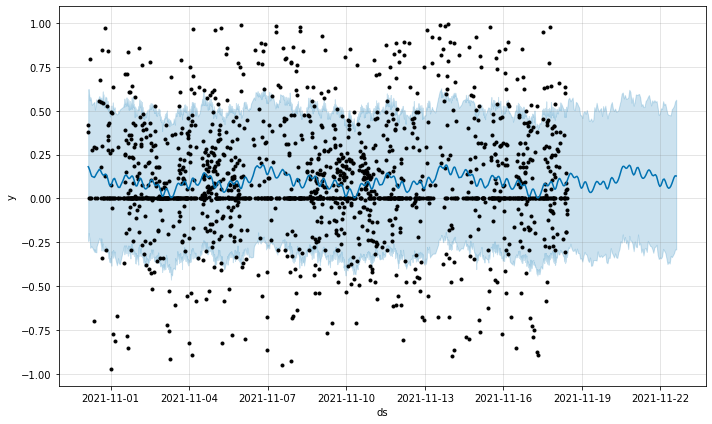

In [84]:
fig1 = sentiment_m.plot(sentiment_forecast)

In [85]:
sentiment_forecast.index = pd.to_datetime(sentiment_forecast.ds)

Add sentiment as additional regressor

In [86]:
m = Prophet(changepoint_prior_scale=0.005, seasonality_prior_scale=.1, seasonality_mode='additive')
m.add_regressor('avg(sentiment)', prior_scale=m.seasonality_prior_scale, standardize=True, mode='additive')
m.fit(tickerdf[['ds', 'close', 'avg(sentiment)']].rename(columns={'ds':'ds', 'close':'y'}))


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [87]:
def fillsentiment(ds):
  return sentiment_forecast.loc[pd.to_datetime(ds), 'yhat']

In [88]:
future = m.make_future_dataframe(periods=100, freq='H')
future['avg(sentiment)'] = future['ds'].apply(fillsentiment)
future.tail()

,ds,avg(sentiment)
1685,2021-11-22 10:31:34,0.084143
1686,2021-11-22 11:31:34,0.102271
1687,2021-11-22 12:31:34,0.119454
1688,2021-11-22 13:31:34,0.129334
1689,2021-11-22 14:31:34,0.128250


In [89]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1685,2021-11-22 10:31:34,20.508615,20.005023,21.021305
1686,2021-11-22 11:31:34,20.521467,19.999326,21.019341
1687,2021-11-22 12:31:34,20.517796,19.994765,21.022386
1688,2021-11-22 13:31:34,20.504093,19.941767,21.027458
1689,2021-11-22 14:31:34,20.497997,19.992145,21.035802


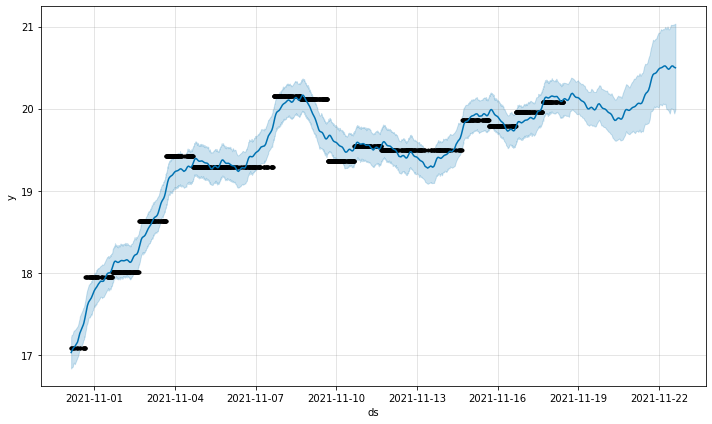

In [90]:
fig1 = m.plot(forecast)

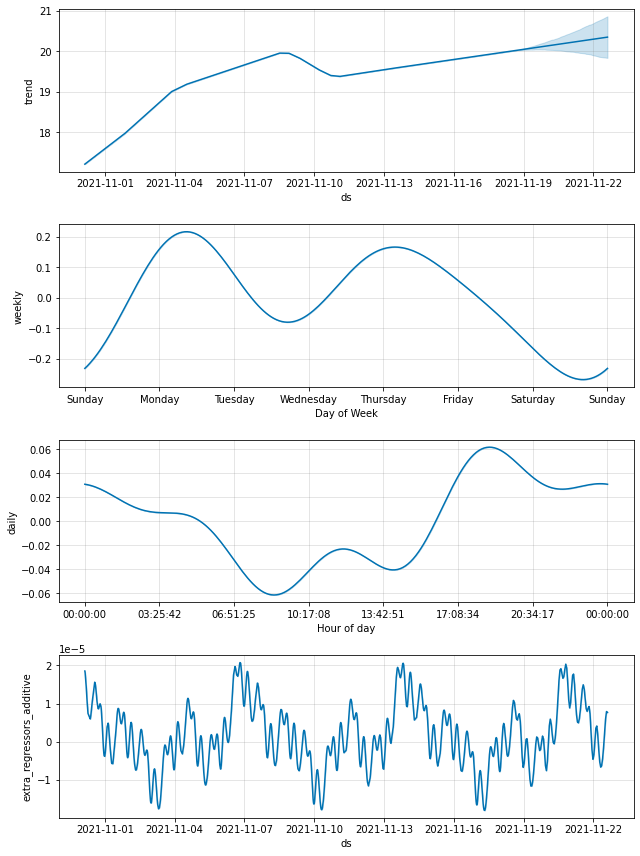

In [91]:
fig2 = m.plot_components(forecast)

In [92]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [93]:
plot_components_plotly(m, forecast)